# Course Project 
### Topics In Applied Optimization
#### B Srinath Dhatre
#### GV Dheeraj Sai
#### SriRama Ratan

Importing the modules

In [ ]:
# Importing Modules

%matplotlib inline
import sys
import copy
import torch
import random
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import random as rnd
import numpy as np
from typing import List, Tuple, Dict


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data

cuda


# GAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm
import numpy as np

class GAE(nn.Module):
    def __init__(self, in_channels, out_channels=2, hidden_dim=64, dropout=0.5):
        super(GAE, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)
        self.bn2 = BatchNorm(out_channels)
        self.dropout = nn.Dropout(p=dropout)
        self.decoder = nn.Linear(out_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x, edge_index))
        print("Size of input data:", x.size())
        print("Size of embeddings:", x.size())
        print("Embeddings:", x)
        return x

    def forward(self, data):
        z = self.encode(data.x, data.edge_index)
        return self.decoder(z)



In [3]:
def train_gae_with_early_stopping(node_features, adj_matrix, epochs=700, lr=0.04, weight_decay=5e-4, patience=20):
    in_channels = node_features.shape[1]
    
    # Define the model inside the training function
    model = GAE(in_channels=in_channels, hidden_dim=64, dropout=0.4).to(device)
    
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long).to(device)
    node_features = torch.tensor(node_features, dtype=torch.float).to(device)
    data = Data(x=node_features, edge_index=edge_index).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    patience_counter = 0
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        reconstructed = model.decoder(z)
        
        loss = criterion(reconstructed, data.x)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return model, data

def calculate_mse(original, reconstructed):
    mse = nn.MSELoss()
    return mse(reconstructed, original).item()

# Set the device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example usage
node_features = np.random.rand(10, 3)
adj_matrix = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
])

# Train the model
model, data = train_gae_with_early_stopping(node_features, adj_matrix, epochs=700, lr=0.04, weight_decay=1e-4, patience=20)

# Perform a forward pass and calculate RMSE
model.eval()
with torch.no_grad():
    embeddings = model.encode(data.x, data.edge_index)
    reconstructed = model.decoder(embeddings)
    
    print("Original Node Features:")
    print(data.x)
    print("\nReconstructed Node Features:")
    print(reconstructed)
    print("Size of input data:", data.x.size())
    print("Size of embeddings:", embeddings.size())
    print("Embeddings:", embeddings)

    rmse_value = torch.sqrt(torch.tensor(calculate_mse(data.x.cpu(), reconstructed.cpu()))).item()
    print("RMSE = ", rmse_value)


Size of input data: torch.Size([10, 2])
Size of embeddings: torch.Size([10, 2])
Embeddings: tensor([[-0.4157, -0.6155],
        [-0.0171, -1.1318],
        [ 0.4697,  0.2884],
        [-0.1482,  1.0650],
        [ 1.5319, -1.1994],
        [ 1.2675, -0.2206],
        [-1.3428,  1.4338],
        [-1.2118,  1.5321],
        [-1.1508, -1.1087],
        [ 1.0172, -0.0432]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 1, Loss: 0.9577827453613281
Size of input data: torch.Size([10, 2])
Size of embeddings: torch.Size([10, 2])
Embeddings: tensor([[ 0.8467,  1.3696],
        [ 2.1442,  0.4895],
        [ 1.0111,  0.9895],
        [-0.7456,  0.3518],
        [-0.8568, -1.5593],
        [ 0.0501, -1.3611],
        [-0.3124, -0.7506],
        [-1.0800,  0.2225],
        [-0.0818,  0.9973],
        [-0.5756, -0.3492]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 2, Loss: 0.6365988254547119
Size of input data: torch.Size([10, 2])
Size of embeddings: torch.

# c2s 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim=19, hidden_dims=[76, 38], output_dim=5):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)  # Linear activation for the output layer
        return x


In [5]:
# Define the Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)



In [ ]:

def get_c2s_action_space(customers, noof_warehouses):
    # Ensure customers and noof_warehouses are defined and populated correctly
    actions = []
    if not customers or noof_warehouses <= 0:
        print("Error: No customers or warehouses provided.")
        return actions

    for customer in customers:
        for warehouse_id in range(noof_warehouses):
            actions.append((customer.customer_id, warehouse_id, 0))  # Assign to warehouse
        actions.append((customer.customer_id, -1, 1))  # Defer customer
    return actions


def train_c2s_agent(env, gae_model, dqn_model, replay_buffer, epochs=1000, batch_size=512, discount_factor=0.9):
    optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        if len(replay_buffer) < batch_size:
            continue
        
        env.reset()
        feature_matrix, adjacency_matrix = env.create_graph_matrices()
        feature_matrix = torch.tensor(feature_matrix, dtype=torch.float).to(device)
        adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.long).to(device)
        
        with torch.no_grad():
            embeddings = gae_model.encode(feature_matrix, adjacency_matrix)
        state = embeddings.flatten().cpu().numpy()

        for t in range(100):  # Assume each episode has max length of 100 steps
            action_space = get_c2s_action_space(env.customers, env.noof_warehouses)
            action_index = dqn_model(torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)).argmax().item()
            action = action_space[action_index]
            reward = env.c2s_rewards(action)
            
            next_feature_matrix, next_adjacency_matrix = env.create_graph_matrices()
            next_feature_matrix = torch.tensor(next_feature_matrix, dtype=torch.float).to(device)
            next_adjacency_matrix = torch.tensor(next_adjacency_matrix, dtype=torch.long).to(device)
            
            with torch.no_grad():
                next_embeddings = gae_model.encode(next_feature_matrix, next_adjacency_matrix)
            next_state = next_embeddings.flatten().cpu().numpy()
            
            done = np.random.choice([0, 1])
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            if done:
                break

        # Sample a batch from replay buffer and update DQN
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        
        current_q_values = dqn_model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = dqn_model(next_states).max(1)[0]
        expected_q_values = rewards + (discount_factor * max_next_q_values * (1 - dones))
        
        loss = criterion(current_q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


def make_decisions(env, gae_model, dqn_model, feature_matrix, adjacency_matrix):
    # Convert the input data to tensors
    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float).to(device)
    edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long).to(device)
    
    # Encode the features to obtain embeddings
    with torch.no_grad():
        embeddings = gae_model.encode(feature_matrix, edge_index)
    state = embeddings.flatten().cpu().numpy()

    # Ensure the state tensor has the correct shape
    state_dim = dqn_model.fc1.in_features  # Get the expected input dimension from the DQN model
    state = state[:state_dim]  # Ensure the state has the correct number of features
    state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)

    # Get the action space
    action_space = get_c2s_action_space(env.customers, env.noof_warehouses)
    print(f'Action space size: {len(action_space)}')
    print(f'Q-values output size: {dqn_model(state).size()}')

    if len(action_space) == 0:
        print("Error: Action space is empty.")
        return []

    # Get the action for the given embeddings
    with torch.no_grad():
        q_values = dqn_model(state)
    action_index = q_values.argmax().item()
    print(f'Action index: {action_index}')

    # Ensure the action index is within bounds
    if action_index >= len(action_space):
        action_index = len(action_space) - 1
    action = action_space[action_index]
    
    return [action]  # Ensure the return value is a list of tuples


# def generate_hardcoded_data():
#     customers = list(range(10))  # 10 customer IDs
#     noof_warehouses = 4  # 4 warehouses
#     feature_matrix = np.array([
#         [0.1, 0.2, 0.3],
#         [0.4, 0.5, 0.6],
#         [0.7, 0.8, 0.9],
#         [1.0, 1.1, 1.2],
#         [1.3, 1.4, 1.5],
#         [1.6, 1.7, 1.8],
#         [1.9, 2.0, 2.1],
#         [2.2, 2.3, 2.4],
#         [2.5, 2.6, 2.7],
#         [2.8, 2.9, 3.0]
#     ])  # Hardcoded feature matrix
#     adjacency_matrix = np.array([
#         [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
#         [1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
#         [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
#         [0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
#         [0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
#         [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#         [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
#         [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
#         [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
#         [0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
#     ])  # Hardcoded adjacency matrix
#     return customers, noof_warehouses, feature_matrix, adjacency_matrix


# # Generate hardcoded data
# customers, noof_warehouses, feature_matrix, adjacency_matrix = generate_hardcoded_data()

# # Initialize models
# gae_model = GAE(in_channels=3, hidden_dim=64, dropout=0.4).to(device)
# dqn_model = DQN(input_dim=19, output_dim=5).to(device)

# # Test the make_decisions function with hardcoded data
# action_example, reward_example = make_decisions(gae_model, dqn_model, customers, noof_warehouses, feature_matrix, adjacency_matrix)
# print(f'Action for the given embeddings: {action_example}, Reward: {reward_example}')




In [ ]:
# Generate synthetic data
def generate_synthetic_data(num_samples=1000, state_dim=19, action_dim=5):
    states = np.random.rand(num_samples, state_dim)
    actions = np.random.randint(0, action_dim, size=(num_samples,))
    rewards = np.random.rand(num_samples)
    next_states = np.random.rand(num_samples, state_dim)
    dones = np.random.choice([0, 1], size=(num_samples,))
    return states, actions, rewards, next_states, dones

states, actions, rewards, next_states, dones = generate_synthetic_data()

# Convert to PyTorch tensors
states = torch.tensor(states, dtype=torch.float).to(device)
actions = torch.tensor(actions, dtype=torch.long).to(device)
rewards = torch.tensor(rewards, dtype=torch.float).to(device)
next_states = torch.tensor(next_states, dtype=torch.float).to(device)
dones = torch.tensor(dones, dtype=torch.float).to(device)


In [ ]:
# Training function
def train_dqn_model(dqn_model, states, actions, rewards, next_states, dones, batch_size=64, discount_factor=0.9, epochs=100):
    optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    num_samples = states.size(0)
    
    for epoch in range(epochs):
        permutation = torch.randperm(num_samples)
        
        for i in range(0, num_samples, batch_size):
            indices = permutation[i:i + batch_size]
            batch_states = states[indices]
            batch_actions = actions[indices]
            batch_rewards = rewards[indices]
            batch_next_states = next_states[indices]
            batch_dones = dones[indices]
            
            current_q_values = dqn_model(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)
            max_next_q_values = dqn_model(batch_next_states).max(1)[0]
            expected_q_values = batch_rewards + (discount_factor * max_next_q_values * (1 - batch_dones))
            
            loss = criterion(current_q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Train the DQN model
train_dqn_model(dqn_model, states, actions, rewards, next_states, dones)


In [ ]:
# Testing function
def test_dqn_model(dqn_model, test_states):
    dqn_model.eval()
    with torch.no_grad():
        q_values = dqn_model(test_states)
        actions = q_values.argmax(1).cpu().numpy()
    return actions

# Generate some test states
test_states = torch.tensor(np.random.rand(10, 19), dtype=torch.float).to(device)

# Get actions for the test states
actions = test_dqn_model(dqn_model, test_states)
print(f'Actions for test states: {actions}')


# VRP

In [7]:
def get_vrp_action_space(customers):
    return list(permutations(customers))

In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VRPLNetwork(nn.Module):
    def __init__(self, input_dim, output_dim ):
        super(VRPLNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, output_dim)  # Adjusted to output the correct number of actions
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

    def make_decisions(self, env, gae_model, feature_matrix, adjacency_matrix):
        # Convert the input data to tensors
        feature_matrix = torch.tensor(feature_matrix, dtype=torch.float).to(device)
        edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long).to(device)
        
        # Encode the features to obtain embeddings
        with torch.no_grad():
            embeddings = gae_model.encode(feature_matrix, edge_index)
        state = embeddings.flatten().cpu().numpy()

        # Ensure the state tensor has the correct shape
        state_dim = self.fc1.in_features  # Get the expected input dimension from the VRP model
        state = state[:state_dim]  # Ensure the state has the correct number of features
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)

        # Get the action space
        action_space = get_vrp_action_space(env.customers)
        print(f'Action space size: {len(action_space)}')
        print(f'Q-values output size: {self(state).size()}')

        if len(action_space) == 0:
            print("Error: Action space is empty.")
            return []

        # Get the action for the given embeddings
        with torch.no_grad():
            q_values = self(state)
        action_index = q_values.argmax().item()
        print(f'Action index: {action_index}')

        # Ensure the action index is within bounds
        if action_index >= len(action_space):
            action_index = len(action_space) - 1
        action = action_space[action_index]
        
        return action  # Return the action tuple







In [9]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)


In [10]:
def get_vrp_action_space(customers):
    return list(permutations(customers))

def train_vrpl_agent(env, gae_model, vrp_model, replay_buffer, epochs=1000, batch_size=512, discount_factor=0.9, lr=0.001):
    optimizer = optim.Adam(vrp_model.parameters())
    criterion = nn.MSELoss()
    epsilon = 1.0
    epsilon_decay = 0.999
    
    for epoch in range(epochs):
        if len(replay_buffer) < batch_size:
            continue
        
        env.reset()
        feature_matrix, adjacency_matrix = env.create_graph_matrices()
        feature_matrix = torch.tensor(feature_matrix, dtype=torch.float).to(device)
        adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.long).to(device)
        
        with torch.no_grad():
            embeddings = gae_model.encode(feature_matrix, adjacency_matrix)
        state = embeddings.flatten().cpu().numpy()

        for t in range(100):  # Assume each episode has max length of 100 steps
            action_space = get_vrp_action_space(env.customers)
            
            if random.random() < epsilon:
                action_index = random.randint(0, len(action_space) - 1)
            else:
                action_values = vrp_model(torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device))
                action_index = torch.softmax(action_values, dim=-1).argmax().item()
                
            vrp_action = action_space[action_index]
            env.input_actions([], vrp_action)  # Apply VRP actions
            
            reward = env.calculate_vrp_reward(vrp_action)
            
            next_feature_matrix, next_adjacency_matrix = env.create_graph_matrices()
            next_feature_matrix = torch.tensor(next_feature_matrix, dtype=torch.float).to(device)
            next_adjacency_matrix = torch.tensor(next_adjacency_matrix, dtype=torch.long).to(device)
            
            with torch.no_grad():
                next_embeddings = gae_model.encode(next_feature_matrix, next_adjacency_matrix)
            next_state = next_embeddings.flatten().cpu().numpy()
            
            done = env.is_done()  # Check if the episode is done
            replay_buffer.push(state, vrp_action, reward, next_state, done)
            state = next_state
            
            if done:
                break

        # Sample a batch from replay buffer and update VRP model
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = batch
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        
        current_q_values = vrp_model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = vrp_model(next_states).max(1)[0]
        expected_q_values = rewards + (discount_factor * max_next_q_values * (1 - dones))
        
        loss = criterion(current_q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epsilon = max(epsilon * epsilon_decay, 0.01)  # Decay epsilon
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / 100}, Epsilon: {epsilon}')

In [ ]:

def fabricate_data(input_dim, action_space_size, num_samples):
    data = []
    for _ in range(num_samples):
        state = np.random.rand(input_dim)
        action = random.randint(0, action_space_size - 1)
        reward = random.random()
        next_state = np.random.rand(input_dim)
        done = random.choice([0, 1])
        data.append((state, action, reward, next_state, done))
    return data

def train_vrpl_agent_fabricated(vrp_model, replay_buffer, input_dim, action_space_size, epochs=1000, batch_size=512, discount_factor=0.9, lr=0.001):
    optimizer = optim.Adam(vrp_model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    epsilon = 1.0
    epsilon_decay = 0.999
    
    for epoch in range(epochs):
        if len(replay_buffer) < batch_size:
            continue

        total_loss = 0
        
        for _ in range(100):  # Assume each episode has max length of 100 steps
            state = np.random.rand(input_dim)
            action_space = list(range(action_space_size))
            
            if random.random() < epsilon:
                action_index = random.randint(0, action_space_size - 1)
            else:
                action_values = vrp_model(torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device))
                action_index = torch.softmax(action_values, dim=-1).argmax().item()
            
            action = action_space[action_index]
            reward = random.random()
            next_state = np.random.rand(input_dim)
            done = random.choice([0, 1])
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            if done:
                break

        # Sample a batch from replay buffer and update VRP model
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = batch
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        
        current_q_values = vrp_model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = vrp_model(next_states).max(1)[0]
        expected_q_values = rewards + (discount_factor * max_next_q_values * (1 - dones))
        
        loss = criterion(current_q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        epsilon = max(epsilon * epsilon_decay, 0.01)  # Decay epsilon
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / 100}, Epsilon: {epsilon}')

# Initialize VRP model and replay buffer
input_dim = 255  # Example input dimension, adjust as needed
action_space_size = 10  # Example action space size, adjust as needed
vrp_model = VRPLNetwork(input_dim).to(device)
replay_buffer = ReplayBuffer(max_size=10000)

# Fabricate data and add to replay buffer
fabricated_data = fabricate_data(input_dim, action_space_size, num_samples=10000)
for data in fabricated_data:
    replay_buffer.push(*data)

# Train VRP agent with fabricated data
train_vrpl_agent_fabricated(vrp_model, replay_buffer, input_dim, action_space_size)


# Environmrnt

In [ ]:
import numpy as np
import random as rnd

class Warehouse:
    def __init__(self, warehouse_id, location, max_inventory):
        self.warehouse_id = warehouse_id
        self.location = location
        self.max_inventory = max_inventory
        self.current_inventory = max_inventory

    def restock(self):
        self.current_inventory = self.max_inventory

class Customer:
    def __init__(self, customer_id, location, demand, time_window, noof_defered=0):
        self.customer_id = customer_id
        self.location = location
        self.demand = demand
        self.time_window = time_window
        self.fulfilled = False
        self.noof_defered = noof_defered
        self.assigned_warehouse_id = None
        self.assigned_vehicle_id = None

class Vehicle:
    def __init__(self, vehicle_id, capacity, speed):
        self.vehicle_id = vehicle_id
        self.capacity = capacity
        self.speed = speed
        self.route = []
        self.current_load = 0

    def reset(self):
        self.route = []
        self.current_load = 0

class Environment:
    def __init__(self, grid_size=200, noof_warehouses=4, noof_customers=400, vehicle_capacity=20, vehicle_speed=2, simulation_time=100, episode_time=5):
        self.grid_size = grid_size
        self.noof_warehouses = noof_warehouses
        self.noof_customers = noof_customers
        self.vehicle_capacity = vehicle_capacity
        self.vehicle_speed = vehicle_speed
        self.simulation_time = simulation_time
        self.episode_time = episode_time
        self.no_of_episodes = simulation_time // episode_time
        self.time_lapsed = 0

        self.warehouses = self._setting_up_warehouses()
        self.vehicles = []
        self.customers = []

    def _setting_up_warehouses(self):
        warehouse_locations = [
            (-self.grid_size / 4, -self.grid_size / 4),
            (self.grid_size / 4, -self.grid_size / 4),
            (-self.grid_size / 4, self.grid_size / 4),
            (self.grid_size / 4, self.grid_size / 4)
        ]
        warehouses = [Warehouse(warehouse_id=i, location=warehouse_locations[i], max_inventory=100) for i in range(self.noof_warehouses)]
        return warehouses

    def generate_customers(self):
        customers_per_episode = self.noof_customers // self.no_of_episodes
        customers_per_episode_rnd = rnd.randint(customers_per_episode // 2, customers_per_episode)
        start = len(self.customers)
        if start + customers_per_episode_rnd > self.noof_customers:
            raise ValueError(f"Attempting to generate {customers_per_episode_rnd} customers exceeds the total allowed {self.noof_customers}.")
        for i in range(start, start + customers_per_episode_rnd):
            x = rnd.uniform(-self.grid_size / 2, self.grid_size / 2)
            y = rnd.uniform(-self.grid_size / 2, self.grid_size / 2)
            demand = rnd.randint(1, 10)
            time_window = (rnd.uniform(0.2, 0.8) * self.grid_size, rnd.uniform(0.9, 2.0) * self.grid_size)
            self.customers.append(Customer(customer_id=i, demand=demand, location=(x, y), time_window=time_window))

    def reset(self):
        for warehouse in self.warehouses:
            warehouse.restock()
        self.vehicles = []
        self.customers = []
        self.generate_customers()

    def distance(self, loc1, loc2):
        return np.sqrt((loc1[0] - loc2[0]) ** 2 + (loc1[1] - loc2[1]) ** 2)

    def norm_1_distance(self, loc1, loc2):
        return np.mod(loc1[0] - loc2[0]) + np.mod(loc1[1] - loc2[1])

    # def create_graph_matrices(self):
    #     feature_matrix = np.random.rand(self.noof_customers, 3)  # Example feature matrix
    #     adjacency_matrix = np.random.randint(0, 2, (self.noof_customers, self.noof_customers))  # Example adjacency matrix
    #     return feature_matrix, adjacency_matrix


    # def simulation_for_each_episode(self, gae_model):
    #     self.generate_customers()
    #     feature_matrix, adjacency_matrix = self.create_graph_matrices()
    #     # Perform a forward pass and calculate RMSE

    #     data = Data(x=feature_matrix, edge_index=adjacency_matrix).to(device)
    #     gae_model.eval()
    #     with torch.no_grad():
    #         embeddings = gae_model.encode(data.x, data.edge_index)
    #     make_decisions(env, gae_model, dqn_model, feature_matrix, adjacency_matrix)
        
    #     self.Rl_Decision(feature_matrix, adjacency_matrix)
    #     self.time_lapsed += self.episode_time

    def simulation(self):
        self.time_lapsed = 0
        self.reset()
        for i in range(self.no_of_episodes):
            self.simulation_for_each_episode()

    def input_actions(self, c2s_decisions, vrp_decisions):
        self.vehicles = []  # Clear the list of vehicles
        vehicle_ids = [decision[0] for decision in vrp_decisions]  # Extract vehicle IDs from vrp_decisions
        noof_vehicles = len(set(vehicle_ids))  # Get unique vehicle count

        for vehicle_id in range(noof_vehicles):
            vehicle = Vehicle(vehicle_id=vehicle_id, capacity=self.vehicle_capacity, speed=self.vehicle_speed)
            self.vehicles.append(vehicle)

        for decision in c2s_decisions:
            customer_id, warehouse_id, defer_flag = decision
            customer = self.customers[customer_id]
            if defer_flag:
                customer.noof_defered += 1
                continue
            warehouse = self.warehouses[warehouse_id]
            if warehouse.current_inventory >= customer.demand:
                customer.assigned_warehouse_id = warehouse_id
                warehouse.current_inventory -= customer.demand
                customer.fulfilled = True
            else:
                customer.noof_defered += 1

        for decision in vrp_decisions:
            vehicle_id, route = decision
            vehicle = self.vehicles[vehicle_id]
            vehicle.reset()

            for customer_id in route:
                customer = self.customers[customer_id]
                warehouse_id = customer.assigned_warehouse_id if customer.assigned_warehouse_id is not None else -1
                if warehouse_id == -1:
                    continue  # Skip if no warehouse assigned
                if customer.fulfilled and vehicle.current_load + customer.demand <= vehicle.capacity:
                    vehicle.route.append(customer.location)
                    vehicle.current_load += customer.demand
                else:
                    customer.noof_defered += 1
                    customer.fulfilled = False

    

    def calculate_c2s_reward(self, decision):
        a1 = 1
        a2 = 2
        customer_id, warehouse_id, defer_flag = decision
        customer = self.customers[customer_id]
        if defer_flag:
            h = customer.noof_defered
            deferred_reward = a1 * (-2.12) + a2 * (-1)
            return np.power(0.9, h) * deferred_reward
        warehouse = self.warehouses[warehouse_id]
        Di = -self.distance(warehouse.location, customer.location)
        trip_customers = sum(1 for c in self.customers if c.assigned_warehouse_id == warehouse_id)
        Li = -Di / max(trip_customers, 1)
        Fi = 1 if customer.fulfilled else 0
        Ui = -((self.vehicle_capacity - customer.demand) / self.vehicle_capacity)
        return a1 * (Di + Li) + Fi + a2 * Ui

    def calculate_vrp_reward(self, decision):
        vehicle_id, route = decision
        vehicle = self.vehicles[vehicle_id]
        P = len(route)
        route_distance = 0
        vrp_rewards = []

        for p, customer_id in enumerate(route):
            customer = self.customers[customer_id]
            warehouse_id = customer.assigned_warehouse_id if customer.assigned_warehouse_id is not None else -1
            if warehouse_id == -1:
                continue  # Skip if no warehouse assigned
            dp = self.distance(vehicle.route[p - 1] if p > 0 else self.warehouses[warehouse_id].location, customer.location)
            tp = dp / vehicle.speed
            Rk_p = (0.7 - dp / self.grid_size) + (1.0 - tp / 1.5) + (0.9 * (P - p))
            vrp_rewards.append(Rk_p)
            route_distance += dp

        if route:
            last_customer = self.customers[route[-1]]
            last_warehouse_id = last_customer.assigned_warehouse_id if last_customer.assigned_warehouse_id is not None else -1
            if last_warehouse_id == -1:
                last_warehouse_id = 0  # Default to the first warehouse if none assigned (or handle appropriately)
            Dreturn = self.distance(vehicle.route[-1], self.warehouses[last_warehouse_id].location)
        else:
            Dreturn = 0
        Rterm = 2 * 0.7 - 1 / (P + 1) * (route_distance + Dreturn)
        vrp_rewards.append(Rterm)

        return vrp_rewards
        
    def create_graph_matrices(self) -> Tuple[np.ndarray, np.ndarray]:
        n_warehouses = len(self.warehouses)
        n_customers = len(self.customers)
        n_nodes = n_warehouses + n_customers

        # Initialize matrices
        feature_matrix = np.zeros((n_nodes, 7))  # 7 features including node ID
        adjacency_matrix = np.zeros((n_nodes, n_nodes))

        # Add warehouse features
        for i, warehouse in enumerate(self.warehouses):
            x, y = warehouse.location
            feature_matrix[i] = [
                x / self.grid_size,  # normalized x
                y / self.grid_size,  # normalized y
                1.0,                 # is_warehouse flag
                warehouse.current_inventory / warehouse.max_inventory,
                0.0,                 # no time window start
                1.0,                 # no time window end
                warehouse.warehouse_id  # warehouse ID
            ]

        # Add customer features
        for i, customer in enumerate(self.customers):
            idx = i + n_warehouses
            x, y = customer.location
            time_start, time_end = customer.time_window
            
            feature_matrix[idx] = [
                x / self.grid_size,
                y / self.grid_size,
                0.0,               # is_warehouse flag
                customer.demand / 10.0,  # normalized demand
                time_start / self.grid_size,
                time_end / self.grid_size,
                customer.customer_id  # customer ID
            ]

        # Create connections in adjacency matrix
        for w_idx, warehouse in enumerate(self.warehouses):
            for c_idx, customer in enumerate(self.customers):
                matrix_idx = c_idx + n_warehouses
                distance = self.distance(warehouse.location, customer.location)
                time_start, time_end = customer.time_window

                is_feasible = (
                    warehouse.current_inventory >= customer.demand and
                    distance <= self.grid_size * 0.7 and
                    time_end - time_start >= distance
                )

                if is_feasible:
                    time_compatibility = 1.0 - (time_start / time_end)
                    edge_weight = 1.0 / (1.0 + distance) * time_compatibility
                    adjacency_matrix[w_idx, matrix_idx] = edge_weight
                    adjacency_matrix[matrix_idx, w_idx] = edge_weight

        # Add customer-to-customer connections
        for i, cust1 in enumerate(self.customers):
            idx1 = i + n_warehouses
            time_start1, time_end1 = cust1.time_window
            
            for j, cust2 in enumerate(self.customers[i+1:]):
                idx2 = j + i + 1 + n_warehouses
                time_start2, time_end2 = cust2.time_window
                distance = self.distance(cust1.location, cust2.location)

                time_compatible = (
                    (time_start1 <= time_start2 and time_end1 <= time_end2) or
                    (time_start2 <= time_start1 and time_end2 <= time_end1)
                )

                if time_compatible and distance <= self.grid_size * 0.3:
                    edge_weight = 1.0 / (1.0 + distance)
                    adjacency_matrix[idx1, idx2] = edge_weight
                    adjacency_matrix[idx2, idx1] = edge_weight

        return feature_matrix, adjacency_matrix

In [ ]:
# Create an instance of the Environment
env = Environment()

# Test resetting the environment
print("Testing environment reset...")
env.reset()
print(f"Number of warehouses: {len(env.warehouses)}")
print(f"Number of customers: {len(env.customers)}")
print("Warehouses after reset:")
for warehouse in env.warehouses:
    print(f"Warehouse ID: {warehouse.warehouse_id}, Location: {warehouse.location}, Current Inventory: {warehouse.current_inventory}")

print("\nCustomers after reset:")
for customer in env.customers:
    print(f"Customer ID: {customer.customer_id}, Location: {customer.location}, Demand: {customer.demand}, Time Window: {customer.time_window}")

# Test generating customers
print("\nTesting customer generation...")
env.generate_customers()
print(f"Number of customers after generation: {len(env.customers)}")

# Test distance calculation
print("\nTesting distance calculation...")
loc1 = (0, 0)
loc2 = (3, 4)
distance = env.distance(loc1, loc2)
print(f"Distance between {loc1} and {loc2}: {distance}")

# Test creating graph matrices
print("\nTesting graph matrix creation...")
feature_matrix, adjacency_matrix = env.create_graph_matrices()
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Adjacency matrix shape: {adjacency_matrix.shape}")

# Test input actions
print("\nTesting input actions...")
c2s_decisions = [(0, 0, 0), (1, 1, 1)]
vrp_decisions = [(0, [0, 1])]
env.input_actions(c2s_decisions, vrp_decisions)
for customer in env.customers:
    print(f"Customer ID: {customer.customer_id}, Fulfilled: {customer.fulfilled}, No. of Deferred: {customer.noof_defered}, Assigned Warehouse: {customer.assigned_warehouse_id}")

# Test reward calculation
print("\nTesting reward calculation...")
c2s_rewards, vrp_rewards = env.calculate_rewards(c2s_decisions, vrp_decisions)
print(f"C2S Rewards: {c2s_rewards}")
print(f"VRP Rewards: {vrp_rewards}")

# Test simulation
print("\nOutput Embeddings...")
print(env.create_graph_matrices())



# Main Code

Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[-0.2689, -1.6878],
        [ 1.5989,  0.8531],
        [-1.1583,  0.2240],
        [-0.1717,  0.6107]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 1, Loss: 1.4533520936965942
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 1.0302, -0.0827],
        [ 0.7539,  1.5290],
        [-0.6779, -0.9733],
        [-1.2663, -0.6330]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 2, Loss: 1.1574887037277222
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 0.9120, -0.0431],
        [ 0.5692,  1.3338],
        [-0.3209, -1.2181],
        [-1.4790, -0.3835]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 3, Loss: 1.0329029560089111
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 0.6926, -

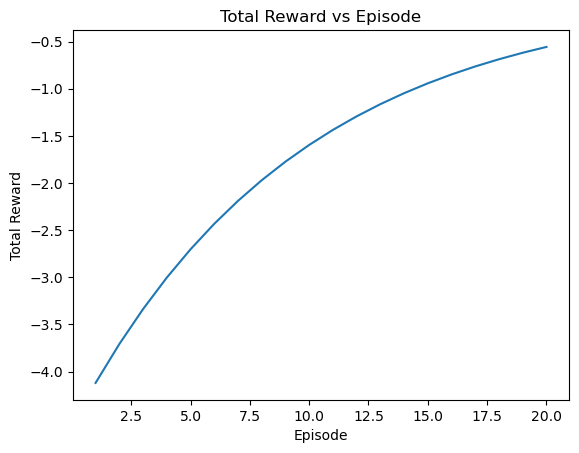

In [15]:
import torch
import torch.nn as nn
import numpy as np
import random
import random as rnd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train():
    env = Environment()
    replay_buffer = ReplayBuffer(10000)  # Example replay buffer
    node_features, adj_matrix = env.create_graph_matrices()
    
    gae_model, gae_data = train_gae_with_early_stopping(node_features, adj_matrix)
    dqn_model = DQN(input_dim=19, output_dim=5).to(device)
    
    train_c2s_agent(env, gae_model, dqn_model, replay_buffer)
    
    return gae_model, dqn_model

# Run the combined train function
gae_model, dqn_model = train()

    

# Assuming the following classes and functions are already defined:
# - Environment
# - GAE
# - DQN
# - make_decisions
# - Customer
# - Warehouse
# - Vehicle

def run_simulation(env, gae_model, dqn_model):
    env.time_lapsed = 0
    env.reset()
    episode_rewards = []

    for episode in range(env.no_of_episodes):
        # Generate new customers at the start of each episode
        env.generate_customers()
        feature_matrix, adjacency_matrix = env.create_graph_matrices()

        # Call the make_decisions function
        c2s_decisions = make_decisions(env, gae_model, dqn_model, feature_matrix, adjacency_matrix)
        print(f'Episode {episode + 1}/{env.no_of_episodes}, C2S Decisions: {c2s_decisions}')

        # Calculate the rewards before applying the actions
        try:
            c2s_reward = sum(env.calculate_c2s_reward(decision) for decision in c2s_decisions)
            print(f'C2S Reward: {c2s_reward}')
        except TypeError as e:
            print(f"Error calculating rewards: {e}. Ensure decisions are in (customer_id, warehouse_id, defer_flag) format.")
            continue

        # Apply input actions to update the environment
        env.input_actions(c2s_decisions, [])
        
        # Calculate total reward for the episode
        total_reward = c2s_reward
        episode_rewards.append(total_reward)
        
        env.time_lapsed += env.episode_time
    
    return episode_rewards

# Example usage
env = Environment()
gae_model = GAE(in_channels=7, hidden_dim=64, dropout=0.4).to(device)
dqn_model = DQN(input_dim=19, output_dim=5).to(device)

# Run the simulation and get episode rewards
episode_rewards = run_simulation(env, gae_model, dqn_model)

# Plot the rewards vs number of episodes
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()


In [ ]:
def train():
    env = Environment()
    replay_buffer_c2s = ReplayBuffer(10000)  # Example replay buffer for C2S
    replay_buffer_vrp = ReplayBuffer(100000)  # Example replay buffer for VRP
    node_features, adj_matrix = env.create_graph_matrices()
    
    gae_model, gae_data = train_gae_with_early_stopping(node_features, adj_matrix)
    dqn_model_c2s = DQN(input_dim=19, output_dim=5).to(device)
    
    # Assuming the GAE model always reduces to 2 dimensions
    input_dim_vrp = 2
    action_space_size = len(get_vrp_action_space(env.customers))
    dqn_model_vrp = VRPLNetwork(input_dim=input_dim_vrp, output_dim=action_space_size).to(device)
    
    # Train C2S and VRP agents
    train_c2s_agent(env, gae_model, dqn_model_c2s, replay_buffer_c2s, epochs=1000, batch_size=512)
    train_vrpl_agent(env, gae_model, dqn_model_vrp, replay_buffer_vrp, epochs=1000, batch_size=64)
    
    return env, gae_model, dqn_model_c2s, dqn_model_vrp


def run_simulation(env, gae_model, dqn_model_c2s, dqn_model_vrp):
    env.time_lapsed = 0
    env.reset()
    episode_rewards = []

    for episode in range(env.no_of_episodes):
        # Generate new customers at the start of each episode
        env.generate_customers()
        feature_matrix, adjacency_matrix = env.create_graph_matrices()

        # Ensure feature_matrix and adjacency_matrix are consistent and correctly sized
        feature_matrix = torch.tensor(feature_matrix, dtype=torch.float).to(device)
        adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.long).to(device)
        print(f"Feature Matrix Shape: {feature_matrix.shape}, Adjacency Matrix Shape: {adjacency_matrix.shape}")

        # Call the make_decisions function for C2S
        c2s_decisions = make_decisions(env, gae_model, dqn_model_c2s, feature_matrix.cpu().numpy(), adjacency_matrix.cpu().numpy())
        print(f'Episode {episode + 1}/{env.no_of_episodes}, C2S Decisions: {c2s_decisions}')

        # Generate VRP decisions using the VRP model's make_decisions method
        vrp_decisions = dqn_model_vrp.make_decisions(env, gae_model, feature_matrix.cpu().numpy(), adjacency_matrix.cpu().numpy())

        # Apply actions to update the environment
        env.input_actions(c2s_decisions, vrp_decisions)
        
        # Calculate the rewards after applying the actions
        c2s_reward = sum(env.calculate_c2s_reward(decision) for decision in c2s_decisions)
        vrp_reward = env.calculate_vrp_reward(vrp_decisions)
        total_reward = c2s_reward + vrp_reward

        print(f'C2S Reward: {c2s_reward}, VRP Reward: {vrp_reward}, Total Reward: {total_reward}')

        episode_rewards.append(total_reward)
        env.time_lapsed += env.episode_time
    
    return episode_rewards

# Main execution
env, gae_model, dqn_model_c2s, dqn_model_vrp = train()

# Run the simulation and get episode rewards
episode_rewards = run_simulation(env, gae_model, dqn_model_c2s, dqn_model_vrp)

# Plot the rewards vs number of episodes
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()


Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 1.3227,  1.5706],
        [ 0.4961, -0.7799],
        [-0.4909, -0.9487],
        [-1.3279,  0.1579]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 1, Loss: 1.1131303310394287
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[-0.3701, -1.2205],
        [ 1.5316, -0.3055],
        [-1.0959,  0.2561],
        [ 0.0943,  1.4298]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 2, Loss: 1.1092489957809448
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 0.1845, -0.3663],
        [ 1.2995, -1.1749],
        [ 0.1069,  0.6214],
        [-1.2935,  1.2352]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)
Epoch 3, Loss: 0.8666138648986816
Size of input data: torch.Size([4, 2])
Size of embeddings: torch.Size([4, 2])
Embeddings: tensor([[ 1.2531, -